In [17]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table
import importlib



<module 'utils.data_processing_gold_table' from '/app/utils/data_processing_gold_table.py'>

## set up pyspark session

In [18]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## Build Bronze Table

In [19]:
# create bronze datalake
bronze_lms_directory = "datamart/bronze/lms/"
bronze_clickstream_directory = "datamart/bronze/clickstream/"
bronze_attr_directory = "datamart/bronze/attributes/"
bronze_fin_directory = "datamart/bronze/fin/"

for directory in [
    bronze_lms_directory,
    bronze_clickstream_directory,
    bronze_attr_directory,
    bronze_fin_directory
]:
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory (if missing): {directory}")

Created directory (if missing): datamart/bronze/lms/
Created directory (if missing): datamart/bronze/clickstream/
Created directory (if missing): datamart/bronze/attributes/
Created directory (if missing): datamart/bronze/fin/


In [20]:
# inspect output
utils.data_processing_bronze_table.process_bronze_table("data/lms_loan_daily.csv",bronze_lms_directory, spark)
utils.data_processing_bronze_table.process_bronze_table("data/feature_clickstream.csv",bronze_clickstream_directory, spark)
utils.data_processing_bronze_table.process_bronze_table("data/features_attributes.csv",bronze_attr_directory, spark)
utils.data_processing_bronze_table.process_bronze_table("data/features_financials.csv",bronze_fin_directory, spark)

Saved 35 bronze files to datamart/bronze/lms/
Saved 24 bronze files to datamart/bronze/clickstream/
Saved 25 bronze files to datamart/bronze/attributes/
Saved 25 bronze files to datamart/bronze/fin/


DataFrame[Customer_ID: string, Annual_Income: string, Monthly_Inhand_Salary: double, Num_Bank_Accounts: int, Num_Credit_Card: int, Interest_Rate: int, Num_of_Loan: string, Type_of_Loan: string, Delay_from_due_date: int, Num_of_Delayed_Payment: string, Changed_Credit_Limit: string, Num_Credit_Inquiries: double, Credit_Mix: string, Outstanding_Debt: string, Credit_Utilization_Ratio: double, Credit_History_Age: string, Payment_of_Min_Amount: string, Total_EMI_per_month: double, Amount_invested_monthly: string, Payment_Behaviour: string, Monthly_Balance: string, snapshot_date: date]

## Build Silver Table

In [21]:
# create bronze datalake
silver_loan_daily_directory = "datamart/silver/loan_daily/"
silver_fin_directory = "datamart/silver/fin/"
silver_attr_directory = "datamart/silver/attributes/"

for directory in [
    silver_loan_daily_directory,
    silver_fin_directory,
    silver_attr_directory
]:
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory (if missing): {directory}")

Created directory (if missing): datamart/silver/loan_daily/
Created directory (if missing): datamart/silver/fin/
Created directory (if missing): datamart/silver/attributes/


In [22]:
utils.data_processing_silver_table.process_silver_table_lms(bronze_lms_directory, silver_loan_daily_directory, spark)
utils.data_processing_silver_table.process_silver_table_attr(bronze_attr_directory, silver_attr_directory, spark)
utils.data_processing_silver_table.process_silver_table_fin(bronze_fin_directory, silver_fin_directory, spark)

[SILVER/LMS] Found 35 bronze LMS partitions...
[SILVER/LMS] Finished writing to datamart/silver/loan_daily/
[SILVER/ATTR] Found 25 bronze attribute partitions...
[SILVER/ATTR] Finished writing to datamart/silver/attributes/
[SILVER/FIN] Found 25 bronze FIN partitions...
[SILVER/FIN] Finished writing to datamart/silver/fin/


True

In [23]:
# --- Financial Table ---
print("=== Silver Financial Table ===")
df_fin = spark.read.parquet("datamart/silver/fin/silver_fin_2023_01_01.parquet")
df_fin.printSchema()
df_fin.show(5, truncate=False)

# --- Attribute Table ---
print("\n=== Silver Attribute Table ===")
df_attr = spark.read.parquet("datamart/silver/attributes/silver_attr_2023_01_01.parquet")
df_attr.printSchema()
df_attr.show(5, truncate=False)

# --- Loan Daily Table ---
print("\n=== Silver Loan Daily Table ===")
df_lms = spark.read.parquet("datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet")
df_lms.printSchema()
df_lms.show(5, truncate=False)


=== Silver Financial Table ===
root
 |-- Customer_ID: string (nullable = true)
 |-- Annual_Income: float (nullable = true)
 |-- Monthly_Inhand_Salary: float (nullable = true)
 |-- Num_Bank_Accounts: float (nullable = true)
 |-- Num_Credit_Card: float (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Num_of_Loan: float (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: float (nullable = true)
 |-- Num_of_Delayed_Payment: float (nullable = true)
 |-- Changed_Credit_Limit: float (nullable = true)
 |-- Num_Credit_Inquiries: float (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: float (nullable = true)
 |-- Credit_Utilization_Ratio: float (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_month: float (nullable = true)
 |-- Amount_invested_monthly: float (nullable = true)
 |-- Payment_Behaviour: string (nullable = true)
 |-- Monthly_Balance: float (nullable = true)


## EDA on credit labels

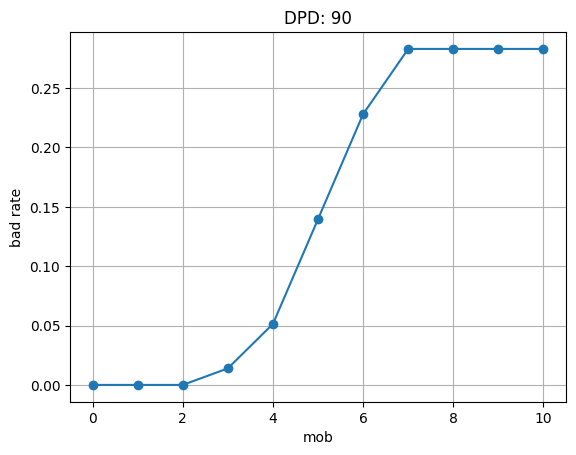

In [24]:
# set dpd label definition
dpd = 90

# Path to the folder containing CSV files
folder_path = silver_loan_daily_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


## Build gold table for labels

In [25]:
# create bronze datalake
gold_label_store_directory = "datamart/gold/label_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

In [26]:
# run gold backfill
utils.data_processing_gold_table.process_labels_gold_table(silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 90, mob = 7)


[GOLD/LABEL] Found 35 silver LMS partitions...
[GOLD/LABEL] Finished writing to datamart/gold/label_store/


True

## inspect label store

In [27]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 12500
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|    0|90dpd_7mob|   2025-03-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|    1|90dpd_7mob|   2025-03-01|
|CUS_0x1145_2024_0...| CUS_0x1145|    1|90dpd_7mob|   2025-03-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|    0|90dpd_7mob|   2025-03-01|
|CUS_0x122c_2024_0...| CUS_0x122c|    0|90dpd_7mob|   2025-03-01|
|CUS_0x1274_2024_0...| CUS_0x1274|    1|90dpd_7mob|   2025-03-01|
|CUS_0x1288_2024_0...| CUS_0x1288|    1|90dpd_7mob|   2025-03-01|
|CUS_0x12cc_2024_0...| CUS_0x12cc|    1|90dpd_7mob|   2025-03-01|
|CUS_0x1338_2024_0...| CUS_0x1338|    0|90dpd_7mob|   2025-03-01|
|CUS_0x1370_2024_0...| CUS_0x1370|    1|90dpd_7mob|   2025-03-01|
|CUS_0x1378_2024_0...| CUS_0x1378|    1|90dpd_7mob|   2025-03-01|
|CUS_0x139b_2024_0...| CUS_0x139b|    0|90dpd_7mob|   2025-

In [28]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)



## Build gold table for features

In [29]:
gold_feature_store_directory = "datamart/gold/feature_store/"
silver_attr_directory = "datamart/silver/attributes/"
silver_fin_directory = "datamart/silver/fin/"
bronze_clickstream_directory = "datamart/bronze/clickstream/"


if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [30]:

utils.data_processing_gold_table.process_features_gold_table(silver_attr_directory, silver_fin_directory, bronze_clickstream_directory, gold_feature_store_directory, spark)

Dropped columns: ['Outstanding_Debt', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']
[GOLD/FE] Found 24 snapshot dates to save.
[GOLD/FE] Writing snapshot 2024_04_01 to datamart/gold/feature_store/gold_feature_store_2024_04_01.parquet
[GOLD/FE] Writing snapshot 2024_03_01 to datamart/gold/feature_store/gold_feature_store_2024_03_01.parquet
[GOLD/FE] Writing snapshot 2024_09_01 to datamart/gold/feature_store/gold_feature_store_2024_09_01.parquet
[GOLD/FE] Writing snapshot 2023_03_01 to datamart/gold/feature_store/gold_feature_store_2023_03_01.parquet
[GOLD/FE] Writing snapshot 2023_01_01 to datamart/gold/feature_store/gold_feature_store_2023_01_01.parquet
[GOLD/FE] Writing snapshot 2023_04_01 to datamart/gold/feature_store/gold_feature_store_2023_04_01.parquet
[GOLD/FE] Writing snapshot 2023_06_01 to datamart/gold/feature_store/gold_feature_store_2023_06_01.parquet
[GOLD/FE] Writing snapshot 2024_11_01 to datamart/gold/feature_store/gold_fe

DataFrame[Customer_ID: string, Annual_Income: float, Monthly_Inhand_Salary: float, Num_Bank_Accounts: float, Num_Credit_Card: float, Interest_Rate: float, Num_of_Loan: float, Delay_from_due_date: float, Num_of_Delayed_Payment: float, Changed_Credit_Limit: float, Num_Credit_Inquiries: float, Credit_Mix: string, Credit_Utilization_Ratio: float, Payment_Behaviour: string, Credit_History_Age: int, Occupation: string, fe_1: int, fe_2: int, fe_3: int, fe_4: int, fe_5: int, fe_6: int, fe_7: int, fe_8: int, fe_9: int, fe_10: int, fe_11: int, fe_12: int, fe_13: int, fe_14: int, fe_15: int, fe_16: int, fe_17: int, fe_18: int, fe_19: int, fe_20: int, snapshot_date: date]